<a href="https://colab.research.google.com/github/teamgaon/KIST/blob/main/220505_ji_Analytics_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import albumentations
import albumentations.pytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
import albumentations as A
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime, timedelta
import random
import torchvision.transforms as transforms
import gc
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [343]:
train = glob('/content/drive/MyDrive/KIST/red_lettuce/*/*.xlsx')
train.sort()

In [344]:
train

['/content/drive/MyDrive/KIST/red_lettuce/CASE1/dataset_20210416.xlsx',
 '/content/drive/MyDrive/KIST/red_lettuce/CASE10/dataset_20210809.xlsx',
 '/content/drive/MyDrive/KIST/red_lettuce/CASE2/dataset_20210504.xlsx',
 '/content/drive/MyDrive/KIST/red_lettuce/CASE3/dataset_20210703.xlsx',
 '/content/drive/MyDrive/KIST/red_lettuce/CASE4/dataset_20210809.xlsx',
 '/content/drive/MyDrive/KIST/red_lettuce/CASE5/dataset_20210703.xlsx',
 '/content/drive/MyDrive/KIST/red_lettuce/CASE6/dataset_20210504.xlsx',
 '/content/drive/MyDrive/KIST/red_lettuce/CASE7/dataset_20210703.xlsx',
 '/content/drive/MyDrive/KIST/red_lettuce/CASE8/dataset_20210809.xlsx',
 '/content/drive/MyDrive/KIST/red_lettuce/CASE9/dataset_20210504.xlsx']

In [345]:
temp = pd.read_excel(train[0])

temp['시간'] = pd.to_datetime(temp['시간'])
temp['년월일'] = temp['시간'].dt.year.astype(str) + '-' + temp['시간'].dt.month.astype(str) + '-' + temp['시간'].dt.day.astype(str)
temp['년월일'] = pd.to_datetime(temp['년월일'])
temp_mean = temp.groupby('년월일').mean()


temp_mean = temp_mean.reset_index(drop=True)
temp_mean['target'] = temp_mean.index


scaler = MinMaxScaler()
scaler.fit(temp_mean)
df = scaler.transform(temp_mean)
df = pd.DataFrame(df, columns=temp_mean.columns)

feature = ['레드 LED동작강도', '블루 LED동작강도', '적색광추정광량', '청색광추정광량', '난방부하', '내부습도관측치',
           '일간누적분무량', '내외부온도차', '외부온도관측치', '외부습도관측치', '내부온도관측치', '냉방부하', 'CO2관측치',
           '총추정광량', '화이트 LED동작강도', '백색광추정광량', '최근분무량', 'target']
df = df[feature]


#idx = df[(df['화이트 LED동작강도']==0) | (df['레드 LED동작강도']==0) | (df['블루 LED동작강도']==0)].index
#df.drop(idx , inplace=True)
df.dropna(inplace=True)

In [346]:
for i in tqdm(range(1,len(train))):
  temp = pd.read_excel(train[i])
  temp.dropna(subset=['시간'],inplace=True)
  temp['시간'] = pd.to_datetime(temp['시간'])
  temp['년월일'] = temp['시간'].dt.year.astype(str) + '-' + temp['시간'].dt.month.astype(str) + '-' + temp['시간'].dt.day.astype(str)
  print(i)
  temp['년월일'] = pd.to_datetime(temp['년월일'])
  temp_mean = temp.groupby('년월일').mean()


  temp_mean = temp_mean.reset_index(drop=True)
  temp_mean['target'] = temp_mean.index


  scaler = MinMaxScaler()
  scaler.fit(temp_mean)
  df_sam = scaler.transform(temp_mean)
  df_sam = pd.DataFrame(df_sam, columns=temp_mean.columns)


  feature = ['레드 LED동작강도', '블루 LED동작강도', '적색광추정광량', '청색광추정광량', '난방부하', '내부습도관측치',
           '일간누적분무량', '내외부온도차', '외부온도관측치', '외부습도관측치', '내부온도관측치', '냉방부하', 'CO2관측치',
           '총추정광량', '화이트 LED동작강도', '백색광추정광량', '최근분무량', 'target']
  df_sam = df_sam[feature]


  #idx = df_sam[(df_sam['화이트 LED동작강도']==0) | (df_sam['레드 LED동작강도']==0) | (df_sam['블루 LED동작강도']==0)].index
  #df_sam.drop(idx , inplace=True)
  df_sam.dropna(inplace=True)

  df = pd.concat([df, df_sam])

 11%|█         | 1/9 [00:22<03:03, 22.98s/it]

1


 22%|██▏       | 2/9 [00:45<02:38, 22.67s/it]

2


 33%|███▎      | 3/9 [01:07<02:14, 22.44s/it]

3


 44%|████▍     | 4/9 [01:30<01:52, 22.54s/it]

4


 56%|█████▌    | 5/9 [01:52<01:30, 22.55s/it]

5


 67%|██████▋   | 6/9 [02:15<01:07, 22.46s/it]

6


 78%|███████▊  | 7/9 [02:37<00:44, 22.39s/it]

7


 89%|████████▉ | 8/9 [03:00<00:22, 22.52s/it]

8


100%|██████████| 9/9 [03:16<00:00, 21.84s/it]

9


In [348]:
df = df.reset_index(drop=True)

In [349]:
df

,레드 LED동작강도,블루 LED동작강도,적색광추정광량,청색광추정광량,난방부하,내부습도관측치,일간누적분무량,내외부온도차,외부온도관측치,외부습도관측치,내부온도관측치,냉방부하,CO2관측치,총추정광량,화이트 LED동작강도,백색광추정광량,최근분무량,target
0,0.870670,0.797762,0.872264,0.801542,0.85711,0.076318,0.717680,0.901651,0.000000,0.483444,0.324143,0.395318,0.296703,0.852921,0.855791,0.858656,0.896177,0.000000
1,0.992256,0.990416,0.996561,0.997229,0.00000,0.017478,0.792618,0.975879,0.188076,0.241492,0.512063,0.466369,0.198588,0.998933,0.996414,0.999305,0.873003,0.025641
2,0.994194,0.993682,0.997975,0.997856,0.00000,0.000000,0.715531,0.988041,0.122473,0.167146,0.470331,0.420781,0.106364,0.998800,0.997117,0.998931,0.906268,0.051282
3,0.994292,0.987036,0.998728,0.996550,0.00000,0.043290,0.767761,1.000000,0.099904,0.217909,0.460843,0.410280,0.232362,0.998091,0.993211,0.998184,0.883998,0.076923
4,0.992870,0.992235,0.997033,0.997334,0.00000,0.124564,0.883952,0.975676,0.309992,0.188386,0.602986,0.565850,0.419970,0.999099,0.996371,0.999454,0.930131,0.102564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1.000000,0.996109,1.000000,1.000000,0.00000,0.977376,0.000000,0.070515,0.899793,0.542302,0.833888,0.754086,0.948402,0.005035,0.007858,0.001084,0.204117,0.750000
282,0.995728,0.992895,0.999343,0.996183,0.00000,0.962087,0.877954,0.418297,0.908299,0.588806,0.900316,0.852529,0.979451,0.002454,0.000000,0.000821,0.952602,0.800000
283,0.994900,0.998025,0.999441,0.995368,0.00000,0.976653,0.287042,0.607974,0.589025,0.769204,0.479341,0.230096,0.916939,0.001504,0.009757,0.000498,0.517327,0.850000
284,0.993331,0.990592,0.998834,0.994739,0.00000,0.973345,0.446641,0.504640,0.648622,0.704629,0.547758,0.331628,0.944072,0.000108,0.007470,0.000147,0.684779,0.900000


## EDA

In [302]:
case3 = pd.read_excel('/content/drive/MyDrive/KIST/red_lettuce/CASE3/dataset_20210703.xlsx')

In [304]:
case3['시간'] = pd.to_datetime(case3['시간'])

In [305]:
case3.head()

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,...,냉방온도,난방온도,기준온도,내외부온도차,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
0,2021-07-03 00:00:00,28.100000,59.900002,535.0,0.0,28.299999,48.700001,0.0,0.0,0.0,...,21.0,20.0,20.5,NaN,0.0,40.500002,0.0,0.0,0.0,0.0
1,2021-07-03 00:01:00,28.200001,57.200001,538.0,0.0,28.299999,48.900002,0.0,0.0,0.0,...,21.0,20.0,20.5,-0.199999,0.0,41.000004,0.0,0.0,0.0,0.0
2,2021-07-03 00:02:00,28.100000,58.200001,540.0,0.0,28.299999,49.000000,0.0,0.0,0.0,...,21.0,20.0,20.5,NaN,0.0,40.500002,0.0,0.0,0.0,0.0
3,2021-07-03 00:03:00,28.100000,58.700001,534.0,0.0,28.299999,48.900002,NaN,NaN,0.0,...,21.0,20.0,20.5,NaN,0.0,40.500002,0.0,0.0,0.0,0.0
4,2021-07-03 00:04:00,28.100000,59.099998,537.0,0.0,28.200001,48.900002,0.0,0.0,0.0,...,21.0,20.0,20.5,-0.100000,0.0,40.500002,0.0,0.0,0.0,0.0


In [306]:
case3['년월일'] = case3['시간'].dt.year.astype(str) + '-' + case3['시간'].dt.month.astype(str) + '-' + case3['시간'].dt.day.astype(str)

In [308]:
case3['년월일'] = pd.to_datetime(case3['년월일'])

In [311]:
sample = case3.groupby('년월일').mean()

In [312]:
sample

,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,...,냉방온도,난방온도,기준온도,내외부온도차,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량
년월일,,,,,,,,,,,,,,,,,,,,,
2021-07-03,29.451875,59.138264,526.459722,0.0,28.700278,52.681250,3.114754,1.952641,706.550472,5370.577861,...,23.395472,22.395472,22.895472,0.749160,0.000000,35.273714,148.009499,148.009499,0.000000,0.000000
2021-07-04,30.585883,60.282615,522.430459,0.0,29.918776,55.179624,3.051786,1.696429,668.522265,5401.855691,...,23.396995,22.396995,22.896995,0.665618,0.000000,40.933755,148.140697,148.140697,0.000000,0.000000
2021-07-05,30.205694,59.071875,547.809722,0.0,29.564305,52.774653,2.677019,1.581189,719.847972,5035.397694,...,23.393964,22.393964,22.893964,0.643396,0.000000,39.055266,147.926406,147.926406,0.000000,0.000000
2021-07-06,29.726250,60.631042,553.707639,0.0,28.868889,58.933958,2.320604,1.321492,691.516271,4398.731465,...,23.397032,22.397032,22.897032,0.851992,0.000000,36.649467,148.138511,148.138511,0.000000,0.000000
2021-07-07,28.353370,63.108061,589.019458,0.0,27.139263,62.668103,3.552120,2.000883,759.387500,5983.247222,...,23.396213,22.396213,22.896213,1.209224,0.000000,29.792943,148.121297,148.121297,0.000000,0.000000
2021-07-08,29.895106,61.142482,550.949610,0.0,29.316394,57.383180,3.519816,1.830415,745.426256,6276.882127,...,23.314473,22.314473,22.814473,0.583440,0.000000,37.798011,143.020434,143.020434,0.000000,0.000000
2021-07-09,30.122569,59.972986,561.594444,0.0,29.559375,55.635278,2.514745,1.487042,761.667354,5486.595021,...,23.395427,22.395427,22.895427,0.564570,0.000000,38.634445,148.049189,148.049189,0.000000,0.000000
2021-07-10,30.544722,59.110139,543.708333,0.0,30.101944,53.187569,3.748668,1.912966,747.061917,5614.716549,...,23.395703,22.395703,22.895703,0.442977,0.000000,40.749002,147.987632,147.987632,0.000000,0.000000
2021-07-11,30.951041,60.040000,541.665972,0.0,30.461736,55.976111,3.021220,1.733864,669.649361,5673.946611,...,23.395912,22.395912,22.895912,0.489518,0.000000,42.776444,148.084150,148.084150,0.000000,0.000000


In [314]:
sample = sample.reset_index(drop=True)

In [316]:
sample['target'] = sample.index

In [317]:
sample

,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,...,난방온도,기준온도,내외부온도차,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,target
0,29.451875,59.138264,526.459722,0.0,28.700278,52.681250,3.114754,1.952641,706.550472,5370.577861,...,22.395472,22.895472,0.749160,0.000000,35.273714,148.009499,148.009499,0.000000,0.000000,0
1,30.585883,60.282615,522.430459,0.0,29.918776,55.179624,3.051786,1.696429,668.522265,5401.855691,...,22.396995,22.896995,0.665618,0.000000,40.933755,148.140697,148.140697,0.000000,0.000000,1
2,30.205694,59.071875,547.809722,0.0,29.564305,52.774653,2.677019,1.581189,719.847972,5035.397694,...,22.393964,22.893964,0.643396,0.000000,39.055266,147.926406,147.926406,0.000000,0.000000,2
3,29.726250,60.631042,553.707639,0.0,28.868889,58.933958,2.320604,1.321492,691.516271,4398.731465,...,22.397032,22.897032,0.851992,0.000000,36.649467,148.138511,148.138511,0.000000,0.000000,3
4,28.353370,63.108061,589.019458,0.0,27.139263,62.668103,3.552120,2.000883,759.387500,5983.247222,...,22.396213,22.896213,1.209224,0.000000,29.792943,148.121297,148.121297,0.000000,0.000000,4
5,29.895106,61.142482,550.949610,0.0,29.316394,57.383180,3.519816,1.830415,745.426256,6276.882127,...,22.314473,22.814473,0.583440,0.000000,37.798011,143.020434,143.020434,0.000000,0.000000,5
6,30.122569,59.972986,561.594444,0.0,29.559375,55.635278,2.514745,1.487042,761.667354,5486.595021,...,22.395427,22.895427,0.564570,0.000000,38.634445,148.049189,148.049189,0.000000,0.000000,6
7,30.544722,59.110139,543.708333,0.0,30.101944,53.187569,3.748668,1.912966,747.061917,5614.716549,...,22.395703,22.895703,0.442977,0.000000,40.749002,147.987632,147.987632,0.000000,0.000000,7
8,30.951041,60.040000,541.665972,0.0,30.461736,55.976111,3.021220,1.733864,669.649361,5673.946611,...,22.395912,22.895912,0.489518,0.000000,42.776444,148.084150,148.084150,0.000000,0.000000,8
9,30.706820,60.353793,553.232591,0.0,30.102925,56.167108,2.494681,1.475177,721.711701,5390.303000,...,22.393861,22.893861,0.600629,0.000000,41.542711,147.919846,147.919846,0.000000,0.000000,9


In [320]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(sample)
sample_scaler = scaler.transform(sample)
sample_scaler = pd.DataFrame(sample_scaler, columns=sample.columns)
sample_scaler

,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,...,난방온도,기준온도,내외부온도차,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,target
0,0.786260,0.139494,0.600456,0.0,0.692485,0.416146,0.008609,0.275449,0.918543,0.204101,...,0.940514,0.940514,0.521325,0.000000,0.784307,0.992620,0.995388,0.000000,0.000000,0.000000
1,0.947938,0.339100,0.574723,0.0,0.844556,0.562207,0.007926,0.229756,0.862342,0.205708,...,0.946165,0.946165,0.482637,0.000000,0.947025,0.996407,0.997755,0.000000,0.000000,0.037037
2,0.893734,0.127914,0.736810,0.0,0.800317,0.421606,0.003864,0.209205,0.938196,0.186886,...,0.934919,0.934919,0.472346,0.000000,0.893021,0.990221,0.993889,0.000000,0.000000,0.074074
3,0.825378,0.399875,0.774478,0.0,0.713528,0.781693,0.000000,0.162891,0.896324,0.154184,...,0.946300,0.946300,0.568945,0.000000,0.823858,0.996344,0.997715,0.000000,0.000000,0.111111
4,0.629643,0.831936,1.000000,0.0,0.497668,1.000000,0.013350,0.284052,0.996631,0.235570,...,0.943264,0.943264,0.734377,0.000000,0.626742,0.995847,0.997405,0.000000,0.000000,0.148148
5,0.849452,0.489085,0.756863,0.0,0.769377,0.691031,0.013000,0.253651,0.975997,0.250652,...,0.639974,0.639974,0.444581,0.000000,0.856877,0.848603,0.905390,0.000000,0.000000,0.185185
6,0.881882,0.285092,0.824847,0.0,0.799702,0.588845,0.002105,0.192415,1.000000,0.210060,...,0.940345,0.940345,0.435843,0.000000,0.880923,0.993766,0.996104,0.000000,0.000000,0.222222
7,0.942070,0.134588,0.710616,0.0,0.867415,0.445746,0.015481,0.268373,0.978415,0.216641,...,0.941369,0.941369,0.379534,0.000000,0.941714,0.991989,0.994994,0.000000,0.000000,0.259259
8,1.000000,0.296781,0.697572,0.0,0.912318,0.608771,0.007595,0.236433,0.864008,0.219683,...,0.942144,0.942144,0.401086,0.000000,1.000000,0.994775,0.996735,0.000000,0.000000,0.296296
9,0.965181,0.351516,0.771444,0.0,0.867538,0.619937,0.001887,0.190299,0.940950,0.205115,...,0.934534,0.934534,0.452541,0.000000,0.964532,0.990032,0.993771,0.000000,0.000000,0.333333


In [321]:
sample_scaler.corr()

,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,일간누적분무량,...,난방온도,기준온도,내외부온도차,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,target
내부온도관측치,1.000000,-0.091477,0.617938,NaN,0.972646,0.341797,0.064669,0.215628,0.405073,0.188743,...,0.126645,0.126811,-0.331609,-0.615757,0.999257,0.379409,0.376500,-0.365795,-0.365885,-0.621524
내부습도관측치,-0.091477,1.000000,-0.228749,NaN,0.073833,-0.000005,0.409949,0.254913,-0.649573,0.285351,...,-0.006319,-0.006683,-0.630934,0.441220,-0.091449,-0.683914,-0.713735,0.727998,0.727910,0.597587
CO2관측치,0.617938,-0.228749,1.000000,NaN,0.527950,0.659932,-0.398923,-0.273695,0.678802,-0.272965,...,0.080860,0.081264,0.091905,-0.381226,0.619000,0.586762,0.600991,-0.602360,-0.602388,-0.759914
EC관측치,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
외부온도관측치,0.972646,0.073833,0.527950,NaN,1.000000,0.205262,0.185805,0.295104,0.229872,0.277282,...,0.125599,0.125652,-0.541649,-0.515356,0.971265,0.192996,0.181775,-0.167012,-0.167104,-0.469143
외부습도관측치,0.341797,-0.000005,0.659932,NaN,0.205262,1.000000,-0.388677,-0.289608,0.532984,-0.321936,...,0.220238,0.220645,0.399602,-0.251765,0.352462,0.550817,0.542228,-0.522563,-0.522595,-0.541723
펌프상태,0.064669,0.409949,-0.398923,NaN,0.185805,-0.388677,1.000000,0.963145,-0.745865,0.971046,...,-0.169294,-0.169147,-0.517235,-0.136700,0.057640,-0.648368,-0.647640,0.633504,0.633231,0.468733
펌프작동남은시간,0.215628,0.254913,-0.273695,NaN,0.295104,-0.289608,0.963145,1.000000,-0.548255,0.989377,...,-0.131614,-0.131327,-0.415455,-0.356134,0.208656,-0.450099,-0.446143,0.433062,0.432754,0.266011
최근분무량,0.405073,-0.649573,0.678802,NaN,0.229872,0.532984,-0.745865,-0.548255,1.000000,-0.588753,...,0.199545,0.199811,0.528798,-0.477771,0.409440,0.927720,0.936574,-0.925732,-0.925643,-0.861043
일간누적분무량,0.188743,0.285351,-0.272965,NaN,0.277282,-0.321936,0.971046,0.989377,-0.588753,1.000000,...,-0.238565,-0.238294,-0.438469,-0.295947,0.177517,-0.524968,-0.507728,0.480409,0.480087,0.314092


In [325]:
df_corr

내부온도관측치         -0.621524
내부습도관측치          0.597587
CO2관측치          -0.759914
EC관측치                 NaN
외부온도관측치         -0.469143
외부습도관측치         -0.541723
펌프상태             0.468733
펌프작동남은시간         0.266011
최근분무량           -0.861043
일간누적분무량          0.314092
냉방상태            -0.663101
냉방작동남은시간        -0.262352
난방상태             0.557720
난방작동남은시간         0.548057
내부유동팬상태          0.343007
내부유동팬작동남은시간           NaN
외부환기팬상태          0.724294
외부환기팬작동남은시간      0.787695
화이트 LED상태        0.214945
화이트 LED작동남은시간    0.436234
화이트 LED동작강도     -0.841780
레드 LED상태         0.192332
레드 LED작동남은시간     0.449522
레드 LED동작강도       0.846017
블루 LED상태         0.271365
블루 LED작동남은시간     0.446938
블루 LED동작강도       0.845642
카메라상태           -0.297564
냉방온도            -0.166705
난방온도            -0.165891
기준온도            -0.166298
내외부온도차          -0.341302
난방부하             0.623041
냉방부하            -0.625782
총추정광량           -0.839261
백색광추정광량         -0.851017
적색광추정광량          0.844771
청색광추정광량          0.844767
target      

In [330]:
df_corr = sample_scaler.corr()['target']
df_corr = pd.DataFrame(df_corr.sort_values(ascending=False), columns=['target'])
df_corr.style.background_gradient(cmap='viridis')

,target
target,1.000000
레드 LED동작강도,0.846017
블루 LED동작강도,0.845642
적색광추정광량,0.844771
청색광추정광량,0.844767
외부환기팬작동남은시간,0.787695
외부환기팬상태,0.724294
난방부하,0.623041
내부습도관측치,0.597587
난방상태,0.557720


In [333]:
df_corr

,target
target,1.000000
레드 LED동작강도,0.846017
블루 LED동작강도,0.845642
적색광추정광량,0.844771
청색광추정광량,0.844767
외부환기팬작동남은시간,0.787695
외부환기팬상태,0.724294
난방부하,0.623041
내부습도관측치,0.597587
난방상태,0.557720


In [336]:
df_corr[abs(df_corr['target'])>=0.3].index

Index(['target', '레드 LED동작강도', '블루 LED동작강도', '적색광추정광량', '청색광추정광량',
       '외부환기팬작동남은시간', '외부환기팬상태', '난방부하', '내부습도관측치', '난방상태', '난방작동남은시간', '펌프상태',
       '레드 LED작동남은시간', '블루 LED작동남은시간', '화이트 LED작동남은시간', '내부유동팬상태', '일간누적분무량',
       '내외부온도차', '외부온도관측치', '외부습도관측치', '내부온도관측치', '냉방부하', '냉방상태', 'CO2관측치',
       '총추정광량', '화이트 LED동작강도', '백색광추정광량', '최근분무량'],
      dtype='object')

In [340]:
feature = ['레드 LED동작강도', '블루 LED동작강도', '적색광추정광량', '청색광추정광량', '난방부하', '내부습도관측치',
           '일간누적분무량', '내외부온도차', '외부온도관측치', '외부습도관측치', '내부온도관측치', '냉방부하', 'CO2관측치',
           '총추정광량', '화이트 LED동작강도', '백색광추정광량', '최근분무량', 'target']

In [341]:
df = sample_scaler[feature]

In [342]:
df

,레드 LED동작강도,블루 LED동작강도,적색광추정광량,청색광추정광량,난방부하,내부습도관측치,일간누적분무량,내외부온도차,외부온도관측치,외부습도관측치,내부온도관측치,냉방부하,CO2관측치,총추정광량,화이트 LED동작강도,백색광추정광량,최근분무량,target
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.139494,0.204101,0.521325,0.692485,0.416146,0.786260,0.784307,0.600456,0.992620,0.950812,0.995388,0.918543,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.339100,0.205708,0.482637,0.844556,0.562207,0.947938,0.947025,0.574723,0.996407,1.000000,0.997755,0.862342,0.037037
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.127914,0.186886,0.472346,0.800317,0.421606,0.893734,0.893021,0.736810,0.990221,0.946407,0.993889,0.938196,0.074074
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.399875,0.154184,0.568945,0.713528,0.781693,0.825378,0.823858,0.774478,0.996344,0.947280,0.997715,0.896324,0.111111
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.831936,0.235570,0.734377,0.497668,1.000000,0.629643,0.626742,1.000000,0.995847,0.943627,0.997405,0.996631,0.148148
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.489085,0.250652,0.444581,0.769377,0.691031,0.849452,0.856877,0.756863,0.848603,0.840260,0.905390,0.975997,0.185185
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.285092,0.210060,0.435843,0.799702,0.588845,0.881882,0.880923,0.824847,0.993766,0.923460,0.996104,1.000000,0.222222
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.134588,0.216641,0.379534,0.867415,0.445746,0.942070,0.941714,0.710616,0.991989,0.931924,0.994994,0.978415,0.259259
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.296781,0.219683,0.401086,0.912318,0.608771,1.000000,1.000000,0.697572,0.994775,0.985256,0.996735,0.864008,0.296296
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.351516,0.205115,0.452541,0.867538,0.619937,0.965181,0.964532,0.771444,0.990032,0.960330,0.993771,0.940950,0.333333


## 모델

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_y = df['target']
df_x = df.drop(columns = ['target'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.2,random_state=0)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(110, 17) (28, 17) (110,) (28,)


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8307527248717066

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.06399934659497818

In [ ]:
y_test.reset_index(drop=True)

0     0.205128
1     0.666667
2     0.743590
3     0.500000
4     0.666667
5     0.750000
6     1.000000
7     0.888889
8     0.642857
9     0.897436
10    0.900000
11    0.717949
12    0.851852
13    0.481481
14    0.925926
15    0.777778
16    0.928571
17    0.564103
18    0.555556
19    0.857143
20    0.851852
21    0.777778
22    0.461538
23    1.000000
24    0.964286
25    0.629630
26    0.642857
27    0.179487
Name: target, dtype: float64

In [ ]:
y_pred

array([0.55710025, 0.79186657, 0.23544047, 0.78982717, 0.80721914,
       0.25009351, 0.56233534, 0.13891267, 0.73606788, 0.4645203 ,
       0.66955632, 0.72355771, 0.40828829, 0.95500008, 0.72004301,
       0.6817568 , 0.75777696, 0.75006981, 0.94986542, 0.7979471 ,
       0.9801148 , 0.24555223, 0.57943492, 0.92188892, 0.90955182,
       0.78911954, 0.69242071, 0.65107877])

In [ ]:
y_test=y_test.values
y_test.sort()

In [ ]:
y_pred.sort()

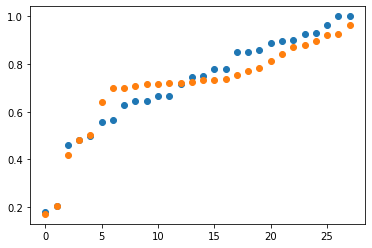

In [ ]:
plt.plot(y_test,"o")
plt.plot(y_pred,"o")
plt.show()

## 몰라

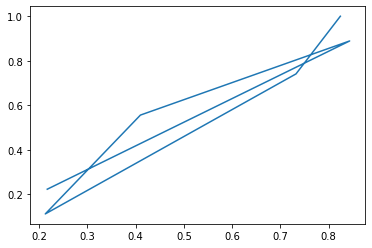

In [ ]:
plt.plot(y_pred,y_test)
plt.show()

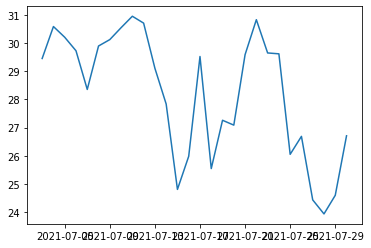

In [ ]:
plt.plot(case3['내부온도관측치'])
plt.show()

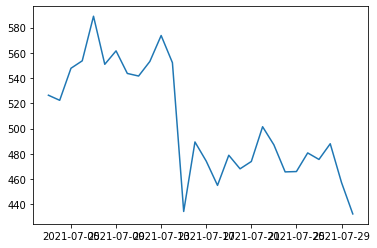

In [ ]:
plt.plot(case3['CO2관측치'])
plt.show()

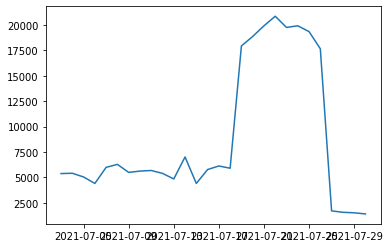

In [ ]:
plt.plot(case3['일간누적분무량'])
plt.show()

In [ ]:
sample

,시간,내부온도관측치,내부습도관측치,CO2관측치,EC관측치,외부온도관측치,외부습도관측치,펌프상태,펌프작동남은시간,최근분무량,...,난방온도,기준온도,내외부온도차,난방부하,냉방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,년월일
0,2021-07-03 00:00:00,28.100000,59.900002,535.0,0.0,28.299999,48.700001,0.0,0.0,0.0,...,20.0,20.5,NaN,0.0,40.500002,0.0,0.0,0.0,0.0,2021-07-03
1,2021-07-03 00:01:00,28.200001,57.200001,538.0,0.0,28.299999,48.900002,0.0,0.0,0.0,...,20.0,20.5,-0.199999,0.0,41.000004,0.0,0.0,0.0,0.0,2021-07-03
2,2021-07-03 00:02:00,28.100000,58.200001,540.0,0.0,28.299999,49.000000,0.0,0.0,0.0,...,20.0,20.5,NaN,0.0,40.500002,0.0,0.0,0.0,0.0,2021-07-03
3,2021-07-03 00:03:00,28.100000,58.700001,534.0,0.0,28.299999,48.900002,NaN,NaN,0.0,...,20.0,20.5,NaN,0.0,40.500002,0.0,0.0,0.0,0.0,2021-07-03
4,2021-07-03 00:04:00,28.100000,59.099998,537.0,0.0,28.200001,48.900002,0.0,0.0,0.0,...,20.0,20.5,-0.100000,0.0,40.500002,0.0,0.0,0.0,0.0,2021-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40294,2021-07-30 23:55:00,27.400000,58.599998,449.0,0.0,28.500000,46.400002,NaN,NaN,126.0,...,20.0,20.5,NaN,0.0,36.999998,0.0,0.0,0.0,0.0,2021-07-30
40295,2021-07-30 23:56:00,27.400000,62.900002,451.0,0.0,28.400000,46.299999,0.0,0.0,126.0,...,20.0,20.5,NaN,0.0,36.999998,0.0,0.0,0.0,0.0,2021-07-30
40296,2021-07-30 23:57:00,27.400000,61.700001,451.0,0.0,28.500000,46.500000,NaN,NaN,126.0,...,20.0,20.5,-1.000000,0.0,36.999998,0.0,0.0,0.0,0.0,2021-07-30
40297,2021-07-30 23:58:00,27.500000,59.200001,452.0,0.0,28.500000,46.400002,0.0,0.0,126.0,...,20.0,20.5,0.000000,37.5,0.000000,0.0,0.0,0.0,NaN,2021-07-30


## 다중선형회귀

In [350]:
from sklearn.model_selection import train_test_split
df_y = df['target']
df_x = df.drop(columns = ['target'])

In [351]:
X_train, X_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.2,random_state=0)

In [352]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(228, 17) (58, 17) (228,) (58,)


In [353]:
model = LinearRegression()
model.fit(X_train, y_train) 

LinearRegression()

In [354]:
y_pred = model.predict(X_test)

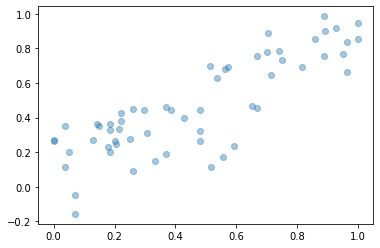

In [355]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred, alpha=0.4)

plt.show()

In [356]:
model.coef_

array([ 4.03478577e-01,  1.21745569e-01, -3.11734146e+00,  2.83584017e+00,
        7.77252137e-02,  1.84414996e-01,  1.83519906e-02, -6.68627764e-02,
        3.11420604e-01,  1.32712478e-01, -7.10039114e-01,  1.93026220e-01,
        5.83148888e-03,  2.34075478e-01, -3.24125049e-01, -1.41134607e-03,
       -1.17906323e-01])

In [357]:
model.score(X_train, y_train)

0.7503423063635262

In [358]:
df.columns

Index(['레드 LED동작강도', '블루 LED동작강도', '적색광추정광량', '청색광추정광량', '난방부하', '내부습도관측치',
       '일간누적분무량', '내외부온도차', '외부온도관측치', '외부습도관측치', '내부온도관측치', '냉방부하', 'CO2관측치',
       '총추정광량', '화이트 LED동작강도', '백색광추정광량', '최근분무량', 'target'],
      dtype='object')

In [359]:
df_x = sm.add_constant(df_x)

In [360]:
import statsmodels.api as sm
result = sm.OLS(df_y,df_x).fit()
result.summary()
#result = sm.ols(formula = 'target ~ 내부온도관측치 + 내부습도관측치 + CO2관측치 + 외부온도관측치 + 외부습도관측치 + 최근분무량 + 일간누적분무량 + 화이트 LED동작강도 + 레드 LED동작강도 + 블루 LED동작강도 + 내외부온도차 + 난방부하 + 냉방부하 + 총추정광량 + 백색광추정광량 + 적색광추정광량 + 청색광추정광량', data =df).fit()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     44.97
Date:                Thu, 05 May 2022   Prob (F-statistic):           2.80e-68
Time:                        07:49:19   Log-Likelihood:                 132.93
No. Observations:                 286   AIC:                            -229.9
Df Residuals:                     268   BIC:                            -164.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4758      0.062      7.643      0.000       0.353       0.598
레드 LED동작강도      0.3982      0.164      2.434      0.016       0.076       0.720
블루 LED동작강도      0.1012      0.302      0.335      0.738      -0.494       0.696
적색광추정광량        -3.1556      1.228     -2.571      0.011      -5.573      -0.739
청색광추정광량         2.8762      1.163      2.474      0.014       0.587       5.165
난방부하            0.0611      0.050      1.219      0.224      -0.038       0.160
내부습도관측치         0.1801      0.064      2.794      0.006       0.053       0.307
일간누적분무량        -0.0021      0.036     -0.060      0.952      -0.073       0.068
내외부온도차         -0.0838      0.064     -1.301      0.194      -0.211       0.043
외부온도관측치         0.2387      0.150      1.590      0.113      -0.057       0.534
외부습도관측치         0.1388      0.058      2.408      0.017       0.025       0.252
내부온도관측치        -0.6509      0.205     -3.172      0.002      -1.055      -0.247
냉방부하            0.2077      0.141      1.476      0.141      -0.069       0.485
CO2관측치         -0.0220      0.041     -0.535      0.593      -0.103       0.059
총추정광량           0.3346      0.165      2.022      0.044       0.009       0.660
화이트 LED동작강도    -0.2930      0.073     -4.039      0.000      -0.436      -0.150
백색광추정광량        -0.1564      0.212     -0.739      0.461      -0.573       0.260
최근분무량          -0.0989      0.036     -2.771      0.006      -0.169      -0.029
==============================================================================
Omnibus:                        1.552   Durbin-Watson:                   0.734
Prob(Omnibus):                  0.460   Jarque-Bera (JB):                1.492
Skew:                           0.177   Prob(JB):                        0.474
Kurtosis:                       2.976   Cond. No.                         435.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [361]:
resid = result.resid

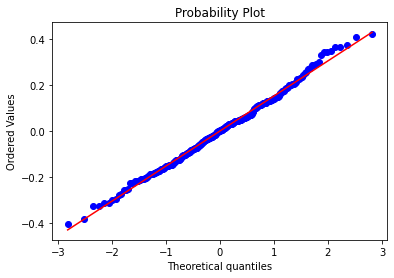

In [362]:
from scipy.stats import probplot
plt.figure()
probplot(resid, plot=plt)
plt.show()

In [363]:
from scipy import stats
stats.shapiro(resid)

(0.9948886036872864, 0.45996949076652527)

In [364]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_x.values, i) for i in range(df_x.shape[1])]
vif["features"] = df_x.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.378609,일간누적분무량
1,1.512912,CO2관측치
2,1.668262,최근분무량
3,1.740901,난방부하
4,2.215667,외부습도관측치
5,3.325184,내부습도관측치
6,4.127244,내외부온도차
7,10.667562,화이트 LED동작강도
8,20.356528,냉방부하
9,22.685794,외부온도관측치


In [365]:
def vif(x):
    # vif 10 초과시 drop을 위한 임계값 설정
    thresh = 10
    # Filter method로 feature selection 진행 후 최종 도출 될 데이터 프레임 형성
    output = pd.DataFrame()
    # 데이터의 컬럼 개수 설정
    k = x.shape[1]
    # VIF 측정
    vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    for i in range(1,k):
        print(f'{i}번째 VIF 측정')
        # VIF 최대 값 선정
        a = np.argmax(vif)
        print(f'Max VIF feature & value : {x.columns[a]}, {vif[a]}')
        # VIF 최대 값이 임계치를 넘지 않는 경우 break
        if (vif[a] <= thresh):
            print('\n')
            for q in range(output.shape[1]):
                print(f'{output.columns[q]}의 vif는 {np.round(vif[q],2)}입니다.')
            break
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        if (i == 1):
            output = x.drop(x.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
        # VIF 최대 값이 임계치를 넘는 경우, + 1번째 이후 시도인 경우 : if 문으로 해당 feature 제거 후 다시 vif 측정
        elif (i > 1):
            output = output.drop(output.columns[a], axis = 1)
            vif = [variance_inflation_factor(output.values, j) for j in range(output.shape[1])]
    return(output)

In [366]:
vif(df_x)

1번째 VIF 측정
Max VIF feature & value : 적색광추정광량, 4181.126336014463
2번째 VIF 측정
Max VIF feature & value : 블루 LED동작강도, 249.6030329745915
3번째 VIF 측정
Max VIF feature & value : 총추정광량, 90.14411820829865
4번째 VIF 측정
Max VIF feature & value : const, 43.524737959214
5번째 VIF 측정
Max VIF feature & value : 내외부온도차, 129.3268851782256
6번째 VIF 측정
Max VIF feature & value : 레드 LED동작강도, 73.13253644525845
7번째 VIF 측정
Max VIF feature & value : 난방부하, 38.72864839742046
8번째 VIF 측정
Max VIF feature & value : 외부온도관측치, 17.651935630418638
9번째 VIF 측정
Max VIF feature & value : 블루 LED동작강도, 12.89397073071125
10번째 VIF 측정
Max VIF feature & value : 내외부온도차, 6.447293549216107


레드 LED동작강도의 vif는 3.45입니다.
난방부하의 vif는 1.62입니다.
일간누적분무량의 vif는 4.72입니다.
내외부온도차의 vif는 5.62입니다.
외부습도관측치의 vif는 6.36입니다.
냉방부하의 vif는 3.66입니다.
CO2관측치의 vif는 4.43입니다.
총추정광량의 vif는 4.78입니다.
최근분무량의 vif는 6.45입니다.


,레드 LED동작강도,난방부하,일간누적분무량,내외부온도차,외부습도관측치,냉방부하,CO2관측치,총추정광량,최근분무량
0,0.870670,0.85711,0.717680,0.901651,0.483444,0.395318,0.296703,0.852921,0.896177
1,0.992256,0.00000,0.792618,0.975879,0.241492,0.466369,0.198588,0.998933,0.873003
2,0.994194,0.00000,0.715531,0.988041,0.167146,0.420781,0.106364,0.998800,0.906268
3,0.994292,0.00000,0.767761,1.000000,0.217909,0.410280,0.232362,0.998091,0.883998
4,0.992870,0.00000,0.883952,0.975676,0.188386,0.565850,0.419970,0.999099,0.930131
...,...,...,...,...,...,...,...,...,...
281,1.000000,0.00000,0.000000,0.070515,0.542302,0.754086,0.948402,0.005035,0.204117
282,0.995728,0.00000,0.877954,0.418297,0.588806,0.852529,0.979451,0.002454,0.952602
283,0.994900,0.00000,0.287042,0.607974,0.769204,0.230096,0.916939,0.001504,0.517327
284,0.993331,0.00000,0.446641,0.504640,0.704629,0.331628,0.944072,0.000108,0.684779


In [367]:
df_x2 = df_x[['레드 LED동작강도',	'난방부하',	'일간누적분무량',	'내외부온도차',	'외부습도관측치',	'냉방부하',	'CO2관측치',	'총추정광량',	'최근분무량']]

In [368]:
df_x2

,레드 LED동작강도,난방부하,일간누적분무량,내외부온도차,외부습도관측치,냉방부하,CO2관측치,총추정광량,최근분무량
0,0.870670,0.85711,0.717680,0.901651,0.483444,0.395318,0.296703,0.852921,0.896177
1,0.992256,0.00000,0.792618,0.975879,0.241492,0.466369,0.198588,0.998933,0.873003
2,0.994194,0.00000,0.715531,0.988041,0.167146,0.420781,0.106364,0.998800,0.906268
3,0.994292,0.00000,0.767761,1.000000,0.217909,0.410280,0.232362,0.998091,0.883998
4,0.992870,0.00000,0.883952,0.975676,0.188386,0.565850,0.419970,0.999099,0.930131
...,...,...,...,...,...,...,...,...,...
281,1.000000,0.00000,0.000000,0.070515,0.542302,0.754086,0.948402,0.005035,0.204117
282,0.995728,0.00000,0.877954,0.418297,0.588806,0.852529,0.979451,0.002454,0.952602
283,0.994900,0.00000,0.287042,0.607974,0.769204,0.230096,0.916939,0.001504,0.517327
284,0.993331,0.00000,0.446641,0.504640,0.704629,0.331628,0.944072,0.000108,0.684779


In [369]:
result2 = sm.OLS(df_y,df_x2).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 target   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.869
Method:                 Least Squares   F-statistic:                              211.3
Date:                Thu, 05 May 2022   Prob (F-statistic):                   1.53e-118
Time:                        07:50:36   Log-Likelihood:                          44.719
No. Observations:                 286   AIC:                                     -71.44
Df Residuals:                     277   BIC:                                     -38.53
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
레드 LED동작강도     0.4235      0.034     12.535      0.000       0.357       0.490
난방부하           0.1395      0.061      2.270      0.024       0.019       0.260
일간누적분무량        0.1189      0.043      2.752      0.006       0.034       0.204
내외부온도차        -0.0709      0.048     -1.475      0.141      -0.166       0.024
외부습도관측치        0.4990      0.055      9.139      0.000       0.392       0.606
냉방부하          -0.0538      0.044     -1.219      0.224      -0.141       0.033
CO2관측치         0.0890      0.049      1.805      0.072      -0.008       0.186
총추정광량          0.0842      0.037      2.300      0.022       0.012       0.156
최근분무량         -0.1405      0.042     -3.323      0.001      -0.224      -0.057
==============================================================================
Omnibus:                       10.032   Durbin-Watson:                   0.636
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               14.086
Skew:                           0.256   Prob(JB):                     0.000874
Kurtosis:                       3.959   Cond. No.                         9.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

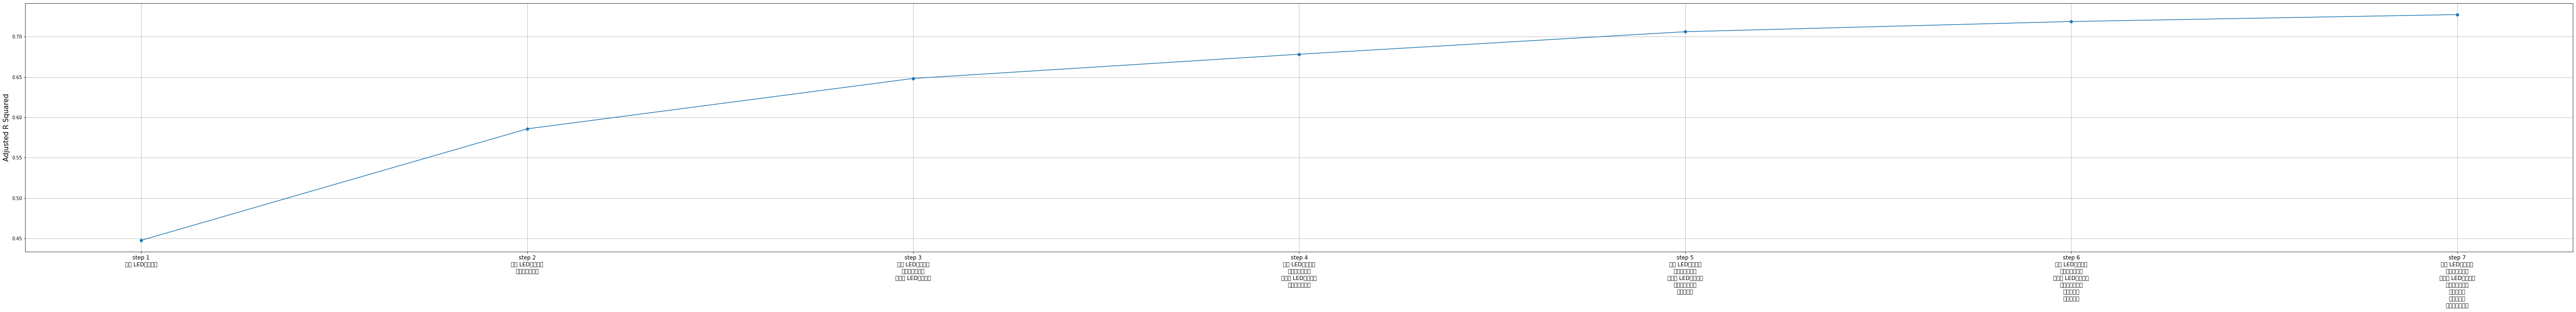

In [379]:
#https://signature95.tistory.com/21?category=986931
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ):
  import statsmodels.api as sm 
  import matplotlib.pyplot as plt 
  import warnings
  warnings.filterwarnings("ignore")
  y = y_train ## 반응 변수 
  selected_variables = [] ## 선택된 변수들 
  sl_enter = 0.05 
  sl_remove = 0.05 
  
  sv_per_step = [] ## 각 스텝별로 선택된 변수들 
  adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
  steps = [] ## 스텝 
  step = 0 
  while len(variables) > 0: 
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value 
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다. 
    for col in remainder:
      X = X_train[selected_variables+[col]] 
      X = sm.add_constant(X) 
      model = sm.OLS(y,X).fit(disp=0) 
      pval[col] = model.pvalues[col] 
      min_pval = pval.min() 
    if min_pval < sl_enter:## 최소 p-value 값이 기준 값보다 작으면 포함 
      selected_variables.append(pval.idxmin()) 
        ## 선택된 변수들에대해서 
        ## 어떤 변수를 제거할지 고른다. 
      while len(selected_variables) > 0:
        selected_X = X_train[selected_variables] 
        selected_X = sm.add_constant(selected_X) 
        selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] 
          ## 절편항의 p-value는 뺀다 
        max_pval = selected_pval.max() 
        if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
          remove_variable = selected_pval.idxmax() 
          selected_variables.remove(remove_variable) 
        else: 
          break 
      step += 1
      steps.append(step) 
      adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
      adjusted_r_squared.append(adj_r_squared) 
      sv_per_step.append(selected_variables.copy()) 
    else: 
      break 
  fig = plt.figure(figsize=(100,10)) 
  fig.set_facecolor('white') 
  
  font_size = 15 
  plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
  plt.plot(steps,adjusted_r_squared, marker='o') 
  plt.ylabel('Adjusted R Squared',fontsize=font_size) 
  plt.grid(True) 
  plt.show() 
  
  return selected_variables 
  
selected_variables = stepwise_feature_selection(X_train, y_train)


In [381]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     87.50
Date:                Thu, 05 May 2022   Prob (F-statistic):           4.92e-60
Time:                        07:53:39   Log-Likelihood:                 105.25
No. Observations:                 228   AIC:                            -194.5
Df Residuals:                     220   BIC:                            -167.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4154      0.050      8.288      

In [383]:
model = LinearRegression()
model.fit(X_train[selected_variables], y_train)
model.score(X_test[selected_variables], y_test)

0.6641669406389676

In [384]:
y_pred = model.predict(X_test[selected_variables])

In [385]:
mean_absolute_error(y_test,y_pred)

0.14788416483105435

In [386]:
df_x = df_x[selected_variables]

In [387]:
model.fit(df_x[selected_variables], df_y)
y_pred = model.predict(df_x[selected_variables])

In [388]:
df_y

0      0.000000
1      0.025641
2      0.051282
3      0.076923
4      0.102564
         ...   
281    0.750000
282    0.800000
283    0.850000
284    0.900000
285    0.950000
Name: target, Length: 286, dtype: float64

In [389]:
df_y.values.shape

(286,)

In [390]:
y_pred.shape

(286,)

In [391]:
result_df = pd.DataFrame()

In [392]:
result_df['test'] = df_y.values
result_df['pred'] = y_pred

In [393]:
result_df

,test,pred
0,0.000000,0.304760
1,0.025641,0.260217
2,0.051282,0.255531
3,0.076923,0.270388
4,0.102564,0.273239
...,...,...
281,0.750000,0.763408
282,0.800000,0.661176
283,0.850000,0.813835
284,0.900000,0.780617


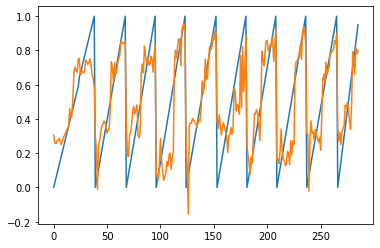

In [394]:
plt.plot(result_df['test'].values)
plt.plot(result_df['pred'])
plt.show()